# Testing the Accuracy of Alignments Under Different Conditions
#### July 27, 2022

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from matplotlib.lines import Line2D
import os
import glob
import torch

from scipy.stats import rankdata
import nrrd
import time

import tools
import time
import datetime

import imp
imp.reload(tools)

/nafs/dtward/torch_venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses


<module 'tools' from '/ifshome/oamiuwu/rasterization_work/tools.py'>

In [2]:
rast_data = [0]*9

slice_names = ['S1R1','S1R2','S1R3','S2R1','S2R2','S2R3','S3R1','S3R2','S3R3']

for i in range(9):
    rast_data[i] = np.load(f"/nafs/dtward/stalign/pca/{slice_names[i]}_arrays.npz")

rast_data[0].files

['X', 'Y', 'W', 'V', 'Z', 'I_pca', 'I_rgb', 'screefig', 'rgbfig']

In [3]:
filename = f"/nafs/dtward/stalign/registration/v01_sigmaM_0.2_S2R3_to_S2R2_transformation_data.npz"
lddmm_data = np.load(filename)
lddmm_data.files

['A',
 'v',
 'xv',
 'figInfo',
 'figE',
 'figAtT',
 'figTtA',
 'TRE',
 'phipointsI',
 'phiipointsJ']

In [4]:
#row/col order
points_s1r1 = np.array([[28,156],[34,193],[49,168],[84,109],[106,234],[193,163],
                       [171,99],[172,237],[195,86],[199,249],[126,43],[134,289]])
points_s1r2 = np.array([[160,58],[121,82],[149,83],[228,84],[112,153],[213,202],
                       [271,165],[158,233],[292,177],[161,254],[300,82],[71,218]])
points_s1r3 = np.array([[102,79],[78,106],[102,103],[166,82],[83,185],[198,207],
                       [233,155],[141,248],[255,160],[144,270],[239,66],[56,243]])
points_s2r1 = np.array([[22,179],[29,205],[95,169],[71,128],[102,228],[224,136],
                       [115,104],[150,220],[105,54],[182,264],[87,149],[99,197],[183,149]])
points_s2r2 = np.array([[250,240],[268,222],[210,179],[165,242],[264,144],[100,102],
                       [130,214],[221,115],[93,247],[245,62],[180,208],[230,158],[135,132]])
points_s2r3 = np.array([[233,173],[231,146],[166,166],[182,227],[167,101],[36,175],
                       [141,231],[126,104],[121,282],[112,55],[169,201],[164,132],[78,172]])
points_s3r1 = np.array([[103,50],[90,58],[135,105],[156,85],[112,119],[194,189],
                       [223,78],[82,188],[257,139],[133,237],[214,178],[178,205]])
points_s3r2 = np.array([[28,174],[32,192],[85,176],[77,121],[94,222],[197,142],
                       [117,50],[154,266],[182,59],[214,223],[204,107],[218,166]])
points_s3r3 = np.array([[176,239],[197,223],[159,175],[141,185],[192,162],[112,71],
                       [56,176],[235,75],[46,99],[180,32],[82,76],[145,40]])
points = [points_s1r1,points_s1r2,points_s1r3,
          points_s2r1,points_s2r2,points_s2r3,
          points_s3r1,points_s3r2,points_s3r3]
points = [p*30. for p in points]

# Evaluating Accuracy with Only an Affine Transformation

In [6]:
i=5
I = tools.normalize(rast_data[i]['I_pca'][:3])
YI = np.array(range(I.shape[1]))*30.
XI = np.array(range(I.shape[2]))*30.

j=4
J = tools.normalize(rast_data[j]['I_pca'][:3])
YJ = np.array(range(J.shape[1]))*30.
XJ = np.array(range(J.shape[2]))*30.

extentI = tools.extent_from_x((YI,XI))
extentJ = tools.extent_from_x((YJ,XJ))

In [6]:
L,T = tools.L_T_from_points(points[i],points[j])
matrix = np.zeros((3,3))
matrix[:2,:2] = L
matrix[:2,2] = T
matrix[2,2] = 1
matrix_ = np.linalg.inv(matrix)

L_ = matrix_[:2,:2]
T_ = matrix_[:2,2]

ApointsI = (L@points[i].T).T + T
ApointsJ = (L_@points[j].T).T + T_

"""fig,ax = plt.subplots(1,2)
ax[0].imshow((I/np.max(I)).transpose(1,2,0),extent=extentI)
ax[1].imshow((J/np.max(J)).transpose(1,2,0),extent=extentJ)
ax[0].scatter(points[i][:,1],points[i][:,0])
ax[1].scatter(points[j][:,1],points[j][:,0])
ax[1].scatter(ApointsI[:,1],ApointsI[:,0],fc=None,ec='r')
fig.suptitle("Atlas to target")

fig,ax = plt.subplots(1,2)
ax[0].imshow((J/np.max(J)).transpose(1,2,0),extent=extentJ)
ax[1].imshow((I/np.max(I)).transpose(1,2,0),extent=extentI)
ax[0].scatter(points[j][:,1],points[j][:,0])
ax[1].scatter(points[i][:,1],points[i][:,0])
ax[1].scatter(ApointsJ[:,1],ApointsJ[:,0],fc=None,ec='r')
fig.suptitle("Target to atlas")"""


'fig,ax = plt.subplots(1,2)\nax[0].imshow((I/np.max(I)).transpose(1,2,0),extent=extentI)\nax[1].imshow((J/np.max(J)).transpose(1,2,0),extent=extentJ)\nax[0].scatter(points[i][:,1],points[i][:,0])\nax[1].scatter(points[j][:,1],points[j][:,0])\nax[1].scatter(ApointsI[:,1],ApointsI[:,0],fc=None,ec=\'r\')\nfig.suptitle("Atlas to target")\n\nfig,ax = plt.subplots(1,2)\nax[0].imshow((J/np.max(J)).transpose(1,2,0),extent=extentJ)\nax[1].imshow((I/np.max(I)).transpose(1,2,0),extent=extentI)\nax[0].scatter(points[j][:,1],points[j][:,0])\nax[1].scatter(points[i][:,1],points[i][:,0])\nax[1].scatter(ApointsJ[:,1],ApointsJ[:,0],fc=None,ec=\'r\')\nfig.suptitle("Target to atlas")'

The following cell shows how applying both an affine and diffeomorphic tranformation to the points lowers the TRE more than just applying an affine transformation.

In [7]:
#2 sets of 6 curves
meanTRE_att, stdTRE_att = np.round(tools.calculate_tre(lddmm_data['phipointsI'], points[j]),3)
meanTRE_tta, stdTRE_tta = np.round(tools.calculate_tre(lddmm_data['phiipointsJ'], points[i]),3)

meanTRE_Aatt, stdTRE_Aatt = np.round(tools.calculate_tre(ApointsI, points[j]),3)
meanTRE_Atta, stdTRE_Atta = np.round(tools.calculate_tre(ApointsJ, points[i]),3)

print(meanTRE_att)
print(meanTRE_Aatt)
print(meanTRE_tta)
print(meanTRE_Atta)

78.197
165.459
78.687
159.468


0.9186895619899029

# Evaluating Accuracy with Varying Numbers of Principal Components

<IPython.core.display.Javascript object>


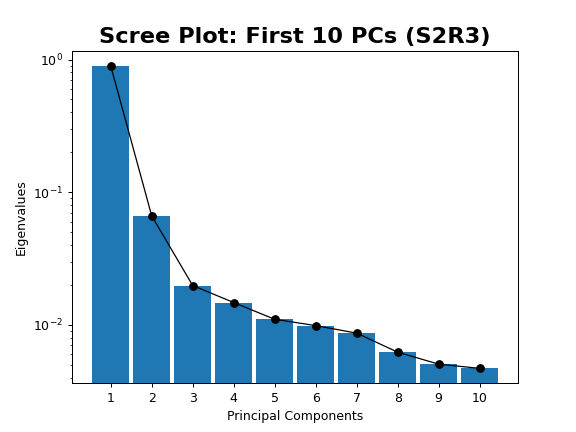

<IPython.core.display.Javascript object>


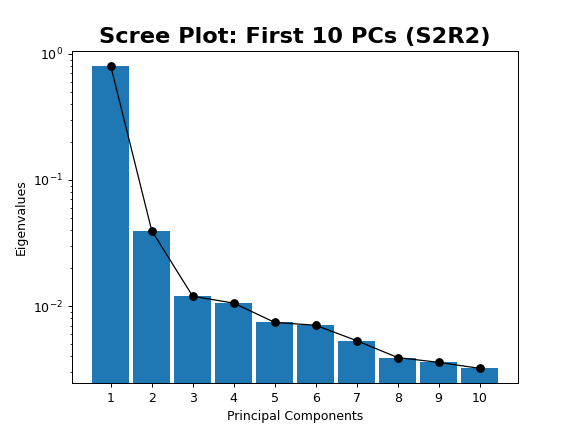

'W = rast_data[j][\'W\']\nW_ = np.cumsum(W)/np.sum(W)\nfor x in range(10):\n    print(f"{x}: {W_[x]}")'

In [7]:
# Scree Plots
fig1 = tools.make_scree(rast_data[i]['W'], slice_names[i],p=10)
plt.gca().set_yscale("log")
fig2 = tools.make_scree(rast_data[j]['W'], slice_names[j],p=10)
plt.gca().set_yscale("log")

#Percentage of variance explained by PCs
"""W = rast_data[j]['W']
W_ = np.cumsum(W)/np.sum(W)
for x in range(10):
    print(f"{x}: {W_[x]}")"""

In [7]:
i=3
j=i+1
for x in range(1,3): #loops through each slice
    for y in range(3): #loops through each replicate of slice as atlas
        for z in range(2): #loops through other 2 replicates of each slice as target
            s=time.time()
            j=(j+z)%3 + 3*x
            YI = np.array(range(rast_data[i]['I_pca'].shape[1]))*30.
            XI = np.array(range(rast_data[i]['I_pca'].shape[2]))*30.
            YJ = np.array(range(rast_data[j]['I_pca'].shape[1]))*30.
            XJ = np.array(range(rast_data[j]['I_pca'].shape[2]))*30.

            L,T = tools.L_T_from_points(points[i],points[j])

            params = {'L':L,'T':T,
#                      'pointsI':points[i],
#                      'pointsJ':points[j],
                      'niter':1000,
                      'device':'cpu',
                      'sigmaM':0.2
                     }
            print(f"{slice_names[i]} to {slice_names[j]}:")
            
            for p in range(1,11):

                start = time.time()
                I = tools.normalize(rast_data[i]['I_pca'][:p])
                J = tools.normalize(rast_data[j]['I_pca'][:p])
                A,v,xv = tools.LDDMM([YI,XI],I,[YJ,XJ],J,**params)

                phipointsI = tools.transform_points_atlas_to_target(xv,v,A,points[i])
                phiipointsJ = tools.transform_points_target_to_atlas(xv,v,A,points[j])

                np.savez(f"/nafs/dtward/stalign/accuracy_noPoints/{slice_names[i]}_to_{slice_names[j]}_transform_{p}_PCs_noPoints",
                         A=A,v=v,xv=xv,phipointsI=phipointsI,phiipointsJ=phiipointsJ)
                
                end = time.time()

                print(f"{p} PCs done. ({str(datetime.timedelta(seconds=(end - start)))})")
            
            e = time.time()
            print(f"Done! Time: {str(datetime.timedelta(seconds=(e - s)))}\n")
            
        i+=1
        j=i+1

S2R1 to S2R2:
1 PCs done. (0:01:01.997442)
2 PCs done. (0:01:01.305742)
3 PCs done. (0:01:16.675636)
4 PCs done. (0:01:29.547505)
5 PCs done. (0:01:23.413941)
6 PCs done. (0:01:27.353221)
7 PCs done. (0:01:26.136128)
8 PCs done. (0:01:50.731536)
9 PCs done. (0:01:53.711999)
10 PCs done. (0:01:56.255189)
Done! Time: 0:14:51.608333

S2R1 to S2R3:
1 PCs done. (0:00:54.033364)
2 PCs done. (0:00:56.345643)
3 PCs done. (0:01:05.531791)
4 PCs done. (0:01:10.189409)
5 PCs done. (0:01:16.974046)
6 PCs done. (0:01:22.819017)
7 PCs done. (0:01:18.643279)
8 PCs done. (0:01:23.318095)
9 PCs done. (0:01:30.131001)
10 PCs done. (0:01:34.947481)
Done! Time: 0:12:35.854508

S2R2 to S2R3:
1 PCs done. (0:01:33.657720)
2 PCs done. (0:01:36.696665)
3 PCs done. (0:01:41.722277)
4 PCs done. (0:01:45.371883)
5 PCs done. (0:01:50.783156)
6 PCs done. (0:01:54.501409)
7 PCs done. (0:01:59.361184)
8 PCs done. (0:02:02.274723)
9 PCs done. (0:02:07.756258)
10 PCs done. (0:02:11.181329)
Done! Time: 0:18:45.624356

S

# Creating Density Transform

In [2]:
# grabs metadata files
meta_files = glob.glob('/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/*metadata*.csv.gz')
meta_files.sort()
gene_files = glob.glob('/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/*by_gene*.csv.gz')

In [3]:
imp.reload(tools)
for file in range(9):
    name = slice_names[file]
    df_meta = pd.read_csv(meta_files[file])
    
    xI = np.array(df_meta['center_x']) # x coordinates
    yI = np.array(df_meta['center_y']) # y coordinates
    g = np.ones(xI.size)
    
    X,Y,I = tools.rasterize(xI,yI,g)
    np.save(f"/nafs/dtward/stalign/pca/{name}_density_image",I)

NameError: name 'slice_names' is not defined

In [5]:
i=0
j=i+1
for x in range(0,3): #loops through each slice
    for y in range(3): #loops through each replicate of slice as atlas
        for z in range(2): #loops through other 2 replicates of each slice as target
            s=time.time()
            j=(j+z)%3 + 3*x
            
            I = tools.normalize(np.load(f"/nafs/dtward/stalign/pca/{slice_names[i]}_density_image.npy"))
            J = tools.normalize(np.load(f"/nafs/dtward/stalign/pca/{slice_names[j]}_density_image.npy"))
            
            YI = np.array(range(I.shape[1]))*30.
            XI = np.array(range(I.shape[2]))*30.
            YJ = np.array(range(J.shape[1]))*30.
            XJ = np.array(range(J.shape[2]))*30.

            L,T = tools.L_T_from_points(points[i],points[j])

            params = {'L':L,'T':T,
#                      'pointsI':points[i],
#                      'pointsJ':points[j],
                      'niter':1000,
                      'device':'cpu',
                      'sigmaM':0.2
                     }   
            
            A,v,xv = tools.LDDMM([YI,XI],I,[YJ,XJ],J,**params)
            phipointsI = tools.transform_points_atlas_to_target(xv,v,A,points[i])
            phiipointsJ = tools.transform_points_target_to_atlas(xv,v,A,points[j])

            np.savez(f"/nafs/dtward/stalign/accuracy_noPoints/{slice_names[i]}_to_{slice_names[j]}_density_transform_noPoints",
                        A=A,v=v,xv=xv,phipointsI=phipointsI,phiipointsJ=phiipointsJ)
                            
            e = time.time()
            print(f"{slice_names[i]} to {slice_names[j]} Time: {str(datetime.timedelta(seconds=(e - s)))}")
            
        i+=1
        j=i+1

/nafs/dtward/torch_venv/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/nafs/dtward/torch_venv/lib/python3.7/site-packages/numpy/lib/npyio.py:719: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  val = np.asanyarray(val)
/nafs/dtward/torch_venv/lib/python3.7/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an nda

S1R1 to S1R2 Time: 0:01:03.773611
S1R1 to S1R3 Time: 0:00:58.464282
S1R2 to S1R3 Time: 0:00:51.964016
S1R2 to S1R1 Time: 0:00:50.535211
S1R3 to S1R1 Time: 0:01:34.283575
S1R3 to S1R2 Time: 0:01:40.617555
S2R1 to S2R2 Time: 0:01:03.001727
S2R1 to S2R3 Time: 0:00:54.779964
S2R2 to S2R3 Time: 0:01:32.963844
S2R2 to S2R1 Time: 0:01:31.810370
S2R3 to S2R1 Time: 0:01:29.775980
S2R3 to S2R2 Time: 0:01:38.041142
S3R1 to S3R2 Time: 0:01:40.685403
S3R1 to S3R3 Time: 0:01:35.585059
S3R2 to S3R3 Time: 0:00:52.674054
S3R2 to S3R1 Time: 0:00:54.354707
S3R3 to S3R1 Time: 0:00:51.581293
S3R3 to S3R2 Time: 0:00:59.166993
